In [1]:
!pip install -q ffmpeg-python

In [2]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import ffmpeg
from IPython.display import Video
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import logging
from itertools import cycle

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


plt.style.use('ggplot')
cm = sns.light_palette("green", as_cmap=True)
pd.option_context('display.max_colwidth', 100)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
# SEED EVERYTHING
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)

# config
class config:
    BASE_DIR = "../input/tensorflow-great-barrier-reef/train_images/"

In [4]:
img_og = plt.imread('../input/tensorflow-great-barrier-reef/train_images/video_1/10004.jpg')
img_9101 = cv2.imread('../input/tensorflow-great-barrier-reef/train_images/video_1/10004.jpg')

In [5]:
df = pd.read_csv('../input/tensorflow-great-barrier-reef/train.csv')
train_dir = "../input/tensorflow-great-barrier-reef/train_images"
df['image_path'] = train_dir + "/video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"
df.head().style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
0,0,40258,0,0,0-0,[],../input/tensorflow-great-barrier-reef/train_images/video_0/0.jpg
1,0,40258,1,1,0-1,[],../input/tensorflow-great-barrier-reef/train_images/video_0/1.jpg
2,0,40258,2,2,0-2,[],../input/tensorflow-great-barrier-reef/train_images/video_0/2.jpg
3,0,40258,3,3,0-3,[],../input/tensorflow-great-barrier-reef/train_images/video_0/3.jpg
4,0,40258,4,4,0-4,[],../input/tensorflow-great-barrier-reef/train_images/video_0/4.jpg


In [6]:
df.info() # lets check more details about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        23501 non-null  int64 
 1   sequence        23501 non-null  int64 
 2   video_frame     23501 non-null  int64 
 3   sequence_frame  23501 non-null  int64 
 4   image_id        23501 non-null  object
 5   annotations     23501 non-null  object
 6   image_path      23501 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.3+ MB


In [7]:
df[df.annotations.str.len() > 2].head(50).style.background_gradient(cmap=cm) # filling up the annotation column

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/16.jpg
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/17.jpg
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/18.jpg
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/19.jpg
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/20.jpg
21,0,40258,21,21,0-21,"[{'x': 550, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/21.jpg
22,0,40258,22,22,0-22,"[{'x': 538, 'y': 209, 'width': 56, 'height': 47}]",../input/tensorflow-great-barrier-reef/train_images/video_0/22.jpg
23,0,40258,23,23,0-23,"[{'x': 535, 'y': 207, 'width': 58, 'height': 48}]",../input/tensorflow-great-barrier-reef/train_images/video_0/23.jpg
24,0,40258,24,24,0-24,"[{'x': 532, 'y': 205, 'width': 59, 'height': 49}]",../input/tensorflow-great-barrier-reef/train_images/video_0/24.jpg
25,0,40258,25,25,0-25,"[{'x': 529, 'y': 200, 'width': 61, 'height': 50}]",../input/tensorflow-great-barrier-reef/train_images/video_0/25.jpg


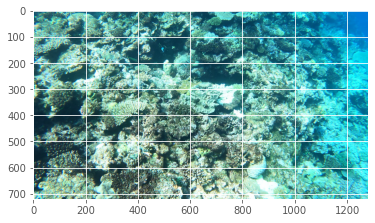

In [8]:
import matplotlib.pyplot as plt

# Assuming df is a DataFrame with an 'annotations' column
filtered_df = df[df.annotations.str.len() > 2].head(50)

# Assuming you have an image path in the 'image_path' column
image_path = filtered_df['image_path'].iloc[30]  # Assuming you want to display the first image in the filtered DataFrame

# Display the image using matplotlib
img = plt.imread(image_path)
plt.imshow(img)
plt.show()


In [9]:
df['annotations'] = df['annotations'].apply(eval)
df_train_v2 = df[df.annotations.str.len() > 0 ].reset_index(drop=True)
df_train_v2.head(5).style.background_gradient(cmap='Reds')

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/16.jpg
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/17.jpg
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/18.jpg
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/19.jpg
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_images/video_0/20.jpg


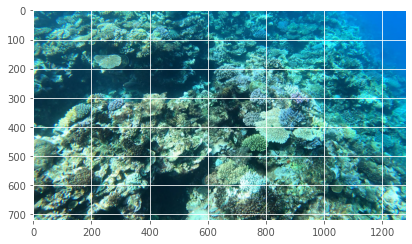

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Select the image path from the first row (or any specific row) of the DataFrame
image_path = df_train_v2['image_path'].iloc[50]

# Read and display the image
img = mpimg.imread(image_path)
plt.imshow(img)  # Turn off axis numbers and labels
plt.show()


# What is Sequence and its properties:

In [11]:
df_train_v2["no_of_bbox"] = df_train_v2["annotations"].apply(lambda x: len(x))
df_train_v2["sequence"].value_counts(), len(df_train_v2["sequence"].value_counts())

(8503     1100
 53708     704
 60754     654
 22643     577
 8399      564
 40258     285
 996       209
 59337     156
 45518     123
 60510     113
 17665      87
 35305      80
 15827      74
 18048      71
 29859      71
 26651      29
 45015      22
 Name: sequence, dtype: int64,
 17)

In [12]:
for i in range(3):
    print(df_train_v2["sequence"][df_train_v2["video_id"] == i].unique(), 
          df_train_v2["sequence"][df_train_v2["video_id"] == i].nunique())

[40258 45518 59337  8399 45015 35305 53708   996] 8
[60510 15827  8503 18048 17665 60754] 6
[26651 22643 29859] 3


# Bounding box analysis in each video:

In [13]:
def plot_with_count(df,vid):
    names = df["bbox_typ"].to_list()
    values = df["counts"].to_list()

    N = len(names)
    menMeans = values
    ind = np.arange(N)

    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    fig, ax = plt.subplots(figsize=(15,6))

    ax.bar(ind,menMeans,width=0.4)
    plt.xticks(np.arange(0, N, step=1))
    plt.title(f"Number of bounding box VS Count of Bounding Box: Video{vid} ",fontsize=20)

    plt.xlabel('Number of bounding box', fontsize=18)
    plt.ylabel('Count', fontsize=16)

    for index,data in enumerate(menMeans):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))

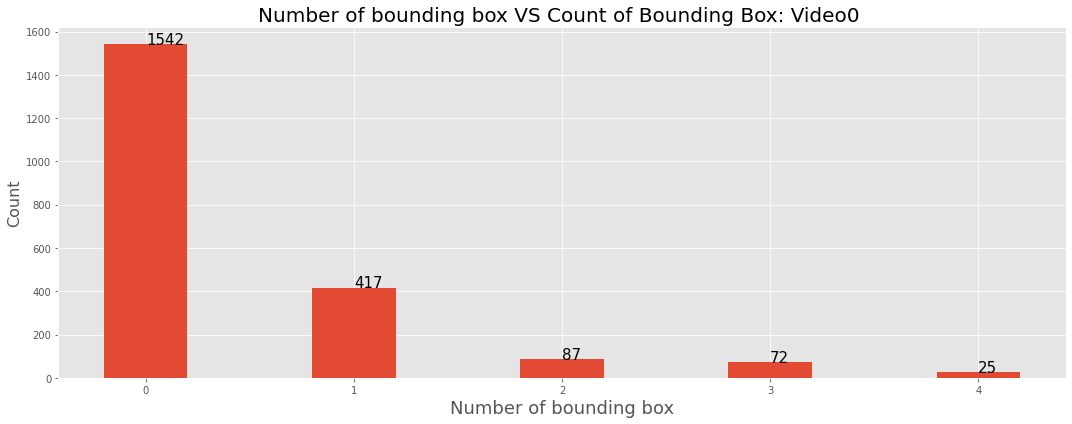

In [14]:
vid = 0
df_vod0_bbox_cnt = df_train_v2["no_of_bbox"][df_train_v2["video_id"] == vid].value_counts().reset_index() # LEARNING .to_frame() and .reset_index()
df_vod0_bbox_cnt.columns = ['bbox_typ', 'counts']
plot_with_count(df_vod0_bbox_cnt,vid)

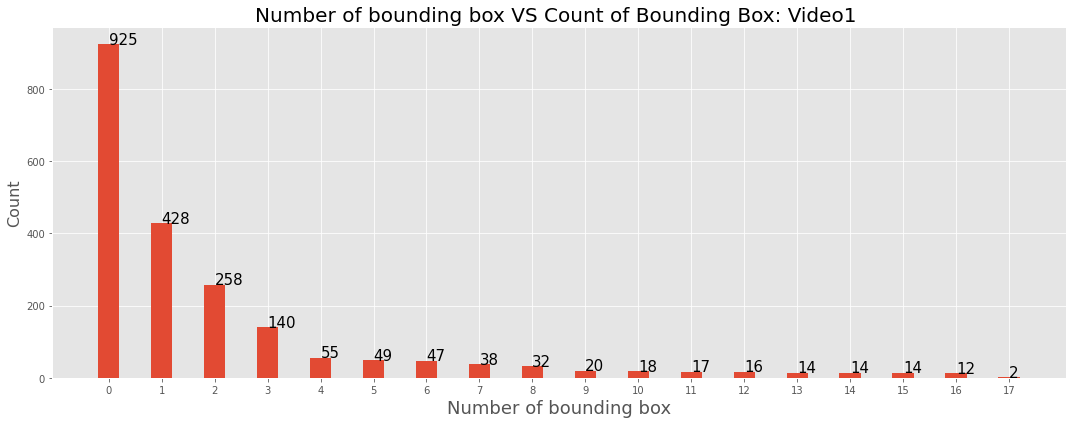

In [15]:
vid = 1
df_vod1_bbox_cnt = df_train_v2["no_of_bbox"][df_train_v2["video_id"] == vid].value_counts().reset_index() # LEARNING .to_frame() and .reset_index()
df_vod1_bbox_cnt.columns = ['bbox_typ', 'counts']
plot_with_count(df_vod1_bbox_cnt,vid)

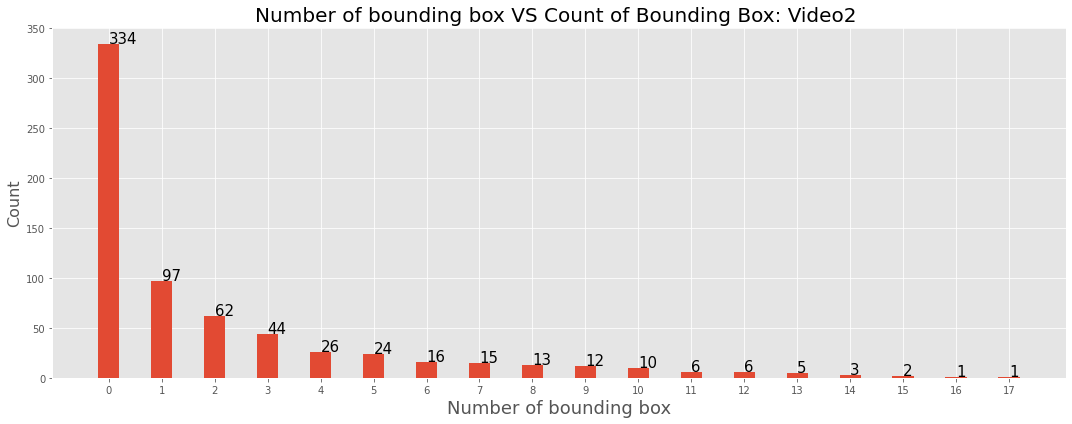

In [16]:
vid = 2
df_vod2_bbox_cnt = df_train_v2["no_of_bbox"][df_train_v2["video_id"] == vid].value_counts().reset_index() # LEARNING .to_frame() and .reset_index()
df_vod2_bbox_cnt.columns = ['bbox_typ', 'counts']
plot_with_count(df_vod2_bbox_cnt,vid)

In [17]:
# https://www.kaggle.com/julian3833/reef-a-cv-strategy-subsequences
df = pd.read_csv("/kaggle/input/tensorflow-great-barrier-reef/train.csv")
df['annotations'] = df['annotations'].apply(eval)
df['n_annotations'] = df['annotations'].str.len()
df['has_annotations'] = df['annotations'].str.len() > 0
df['has_2_or_more_annotations'] = df['annotations'].str.len() >= 2
df['doesnt_have_annotations'] = df['annotations'].str.len() == 0
df['image_path'] = config.BASE_DIR + "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

In [18]:
df_agg = df.groupby(["video_id", 'sequence']).agg({'sequence_frame': 'count', 'has_annotations': 'sum', 'doesnt_have_annotations': 'sum'})\
           .rename(columns={'sequence_frame': 'Total Frames', 'has_annotations': 'Frames with at least 1 object', 'doesnt_have_annotations': "Frames with no object"})
df_agg

Total Frames  Frames with at least 1 object  \
video_id sequence                                                
0        996                923                            209   
         8399              1423                            564   
         35305              853                             80   
         40258              480                            285   
         45015              617                             22   
         45518              798                            123   
         53708             1077                            704   
         59337              537                            156   
1        8503              2843                           1100   
         15827              770                             74   
         17665               87                             87   
         18048               71                             71   
         29424              184                              0   
         44160              151                              0   
         60510             1167                            113   
         60754             2959                            654   
2        22643             1248                            577   
         26651             1525                             29   
         29859             2988                             71   
         37114             2800                              0   

                   Frames with no object  
video_id sequence                         
0        996                         714  
         8399                        859  
         35305                       773  
         40258                       195  
         45015                       595  
         45518                       675  
         53708                       373  
         59337                       381  
1        8503                       1743  
         15827                       696  
         17665                         0  
         18048                         0  
         29424                       184  
         44160                       151  
         60510                      1054  
         60754                      2305  
2        22643                       671  
         26651                      1496  
         29859                      2917  
         37114                      2800

In [19]:
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

def RecoverCLAHE(sceneRadiance):
    clahe = cv2.createCLAHE(clipLimit=7, tileGridSize=(14, 14))
    for i in range(3):
        sceneRadiance[:, :, i] = clahe.apply((sceneRadiance[:, :, i]))
    return sceneRadiance

# Directory where the modified images will be saved
dest_path1 = "./clahe_img"

# Check if the directory exists; if not, create it
if not os.path.exists(dest_path1):
    os.mkdir(dest_path1)

# Processing and saving images
for img_path in tqdm(df_train_v2["image_path"][0:400]):
    image_cv = cv2.imread(img_path)
    img_clahe = RecoverCLAHE(image_cv)
    file_name = img_path.split("/")[-1]
    
    cv2.imwrite(os.path.join(dest_path1, file_name), img_clahe)


100%|██████████| 400/400 [00:33<00:00, 12.00it/s]


In [20]:
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

dest_path1 = "./annot_img"

# Check if the directory exists; if not, create it
if not os.path.exists(dest_path1):
    os.mkdir(dest_path1)

idx = 0
for img_idx in tqdm(df_train_v2["image_path"][0:400]):
    file_name = img_idx.split("/")[-1]
    img_path = os.path.join("./clahe_img", file_name)
    image = plt.imread(img_path)

    for i in range(len(df_train_v2["annotations"][idx])):
        b_boxs = df_train_v2["annotations"][idx][i]
        x, y, w, h = b_boxs["x"], b_boxs["y"], b_boxs["width"], b_boxs["height"]

        image = cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 3)
        image = cv2.putText(image, 'starfish', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Saving the image with annotations
    cv2.imwrite(os.path.join(dest_path1, file_name), image)
    idx += 1


100%|██████████| 400/400 [00:19<00:00, 20.42it/s]


In [21]:
img_sizes = []
for i in df_train_v2["image_path"]:
    img_sizes.append(plt.imread(i).shape)

np.unique(img_sizes)

array([   3,  720, 1280])

In [22]:
# lets check total number of images with annotations
len(df_train_v2)

4919

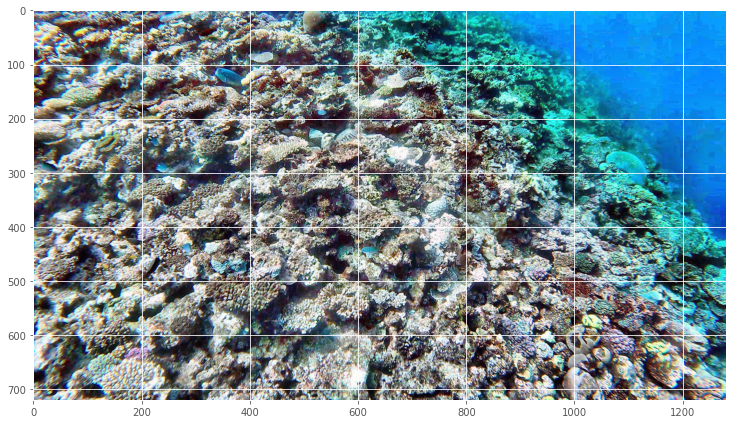

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the size of the figure
plt.figure(figsize=(20, 6))

# Load the image from the 'clahe_img' directory
clahe_image = mpimg.imread('./clahe_img/19.jpg')

# Display the image
plt.imshow(clahe_image)
#plt.axis('off')  # Hide the axis
plt.show()


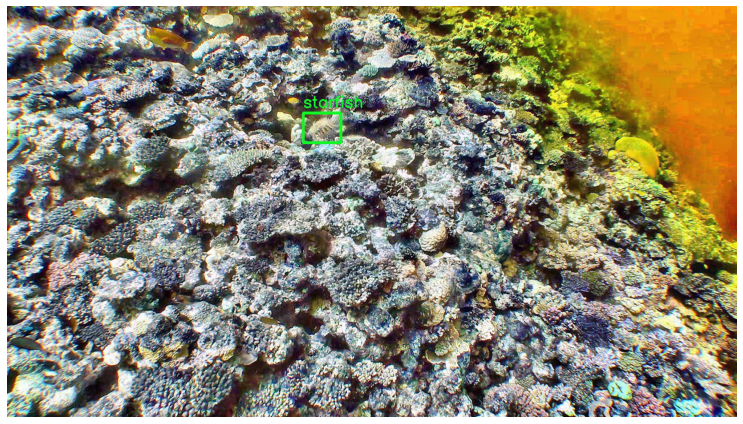

In [26]:
#display annot_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the size of the figure
plt.figure(figsize=(20, 6))

# Load the annotated image from the 'annot_img' directory
annotated_image = mpimg.imread('./annot_img/28.jpg')

# Display the annotated image
plt.imshow(annotated_image)
plt.axis('off')  # Hide the axis
plt.show()
